In [1]:
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import copy
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import rcParams
import seaborn as sns

In [2]:
city_hour = pd.read_csv("city_hour.csv")
delhi_hour = city_hour[city_hour['City']=='Delhi']
delhi_hour['DT'] = delhi_hour['Datetime'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
delhi_daily = delhi_hour.groupby(pd.Grouper(key='DT', freq='D')).mean()
delhi_pm25 = delhi_daily['PM2.5']
delhi_pm25.isna().sum()
delhi_pm25.fillna(method='ffill', inplace=True)

/var/folders/h2/sz1p61zn2sj13_34gp_3y3zm0000gn/T/ipykernel_6251/2312698427.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delhi_hour['DT'] = delhi_hour['Datetime'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
/var/folders/h2/sz1p61zn2sj13_34gp_3y3zm0000gn/T/ipykernel_6251/2312698427.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  delhi_daily = delhi_hour.groupby(pd.Grouper(key='DT', freq='D')).mean()


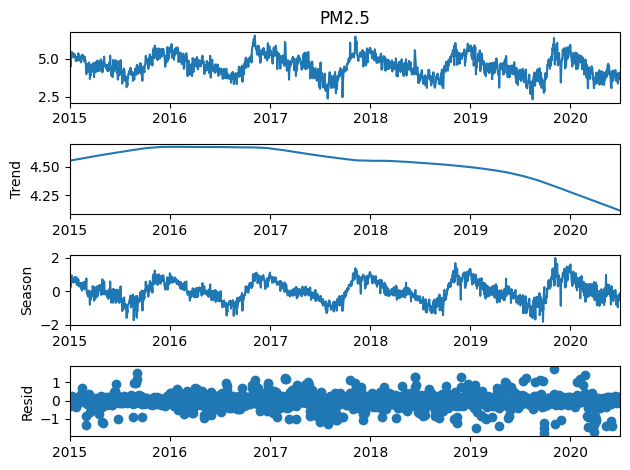

In [3]:
from statsmodels.tsa.seasonal import STL

stl = STL(np.log(delhi_pm25), period = 365,  seasonal = 365, robust = True, trend_deg = 1, low_pass_deg = 1,seasonal_jump=2010, trend_jump=55, low_pass_jump=37 )
res = stl.fit()
fig = res.plot()

{'whiskers': [<matplotlib.lines.Line2D at 0x16e279510>,
 'caps': [<matplotlib.lines.Line2D at 0x16e27a8f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x16e278a90>],
 'medians': [<matplotlib.lines.Line2D at 0x16e27b070>],
 'fliers': [<matplotlib.lines.Line2D at 0x16e27ab00>],
 'means': []}

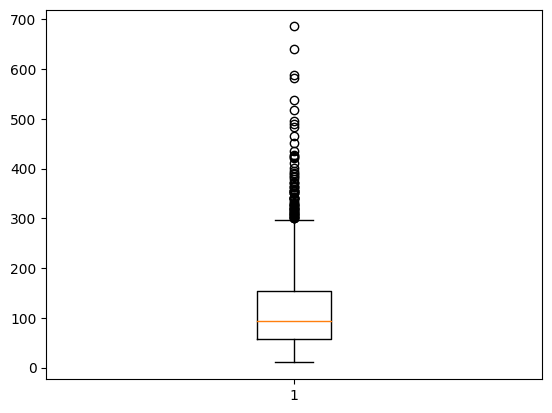

In [5]:
plt.boxplot(delhi_pm25)

In [6]:
%load_ext rpy2.ipython
python_var = "Hello from Python!"
%R -i python_var
%R print(python_var)
%R r_var <- "Hello from R!"
%R -o r_var
print(r_var)

%R library(forecast)
%R library(TSA)
%R library(lubridate)
%R library(mgcv)

%R -i delhi_pm25

%R myts <- ts(log(delhi_pm25), frequency=365)
%R out = tsoutliers((myts)) 
%R out$index
%R myts = replace((myts), out$index, out$replacements)
%R myts <- exp(myts)
%R -o myts



# %R temp_fit <- log(myts) %>% tbats(seasonal.periods = c(365.25)) 
# %R resids = log(myts) - temp_fit$fitted.values
# %R qs = quantile(resids)
# %R iqr_resids = qs[4] - qs[2]
# %R outliers_ind = which((resids < (qs[2] - (2.75*iqr_resids))) | (resids > (qs[4]+(2.75*iqr_resids)) ) ,arr.ind = TRUE)
# %R resids[outliers_ind] <- NA
# %R missng <- is.na(resids)
# %R tt = 1:length(resids)
# %R idx <- tt[!missng]
# %R new_resids = (ts(approx(idx, resids[idx], tt, rule = 2)$y, frequency=365))
# %R new_ts = (new_resids+temp_fit$fitted.values)
# %R -o new_ts

[1] "Hello from Python!"
['Hello from R!']


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
This is forecast 8.21 
  Use suppressPackageStartupMessages() to eliminate package startup messages.


Registered S3 methods overwritten by 'TSA':
  method       from    
  fitted.Arima forecast
  plot.Arima   forecast

Attaching package: ‘TSA’

The following objects are masked from ‘package:stats’:

    acf, arima

The following object is masked from ‘package:utils’:

    tar




Attaching package: ‘lubridate’

The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Loading required package: nlme

Attaching package: ‘nlme’

The following object is masked from ‘package:forecast’:

    getResponse

This is mgcv 1.8-41. For overview type 'help("mgcv-package")'.


In [7]:
delhi_pm25 = pd.Series(myts, index = delhi_pm25.index)
#delhi_pm25 = pd.Series(np.exp(new_ts), index = delhi_pm25.index)

In [8]:
compression_opts = dict(method='zip',
                        archive_name='out2.csv')  
pd.DataFrame(delhi_pm25).to_csv('out2.zip',
          compression=compression_opts)

In [9]:
%R library(forecast)
%R library(TSA)
%R library(lubridate)
%R library(mgcv)

%R -i delhi_pm25
%R myts <- ts((delhi_pm25), frequency=365)
%R myts <- log(myts)


%R train = ts(myts[1:(length(myts)-329)], frequency = 365)
%R test =  myts[(length(myts)-328):length(myts)]


#TBATS
%R fit <- train %>% tbats(seasonal.periods = c(365.25)) 
#Forecasting the Same
%R fc <- forecast(fit, length(test))
%R forecast_tbats <- fc$mean
%R -o forecast_tbats
%R resids_tbats <- fc$residuals
%R -o resids_tbats
%R fitted_tbats <- fc$fitted
%R -o fitted_tbats

#DHR
%R fourier_terms = fourier(train, K = 4)
%R model <- auto.arima(train, xreg=fourier_terms, seasonal=FALSE, lambda=0)
%R fc_dhr = forecast(model, xreg=fourier(train, K=4, h=length(test)))
%R forecast_dhr = (fc_dhr$mean)
%R fitted_dhr = (fc_dhr$fitted)
%R resids_dhr = fc_dhr$residuals
%R -o forecast_dhr
%R -o fitted_dhr
%R -o resids_dhr

%R new_data = read.csv("out2.csv", header = T)
%R new_data$X0 = ts(log(new_data$X0), frequency=365)
%R new_data$DT = as.Date(new_data$DT, format = "%Y-%m-%d")
%R new_data[,'quarter'] = quarter(new_data$DT)
%R new_data[,'week'] = week(new_data$DT)
%R new_data[,'year'] = year(new_data$DT)
%R new_data[,'month'] = month(new_data$DT)
%R new_data[,'cont'] = seq(length(myts))/length(myts) + 1
%R new_data[,'day_num'] = yday(new_data$DT)
%R pred_set = new_data[(length(myts)-328):(length(myts)),c('year','day_num')]
#%R ctrl<-list(niterEM = 0, optimMethod = "L-BFGS-B", maxIter = 100, msMaxIter = 100, msVerbose=TRUE)
%R gam_model_2 = gam(X0 ~ s(year, k=5, bs="cr")+ s(day_num,k=16, bs="cp") , data = new_data[1:(length(myts)-329),], family = gaussian, method = "REML")

%R preds_gam_2 = predict(gam_model_2, newdata = pred_set, type = "response")
%R ar_errors = auto.arima(gam_model_2$residuals)
%R resids_gam = new_data[1:(length(myts)-329), 'X0'] - ar_errors$fitted - gam_model_2$fitted.values
%R fitted_gam = ar_errors$fitted + gam_model_2$fitted.values
%R ar_for = forecast(ar_errors, h = length(pred_set[[1]]))
%R forecast_gam = (as.numeric(preds_gam_2) + ar_for$mean)
%R -o forecast_gam
%R -o fitted_gam
%R -o resids_gam

In [10]:
fitted_tbats = np.exp(fitted_tbats)
forecast_tbats = np.exp(forecast_tbats)
fitted_dhr = np.exp(fitted_dhr)
forecast_dhr = np.exp(forecast_dhr)
fitted_gam = np.exp(fitted_gam)
forecast_gam = np.exp(forecast_gam)

In [117]:
mean_squared_error(delhi_pm25.iloc[:-329,], fitted_gam, squared = False)

37.17811526889392

In [37]:
mean_squared_error(delhi_pm25.iloc[-329:,], forecast_tbats, squared = False)

54.7537005153939

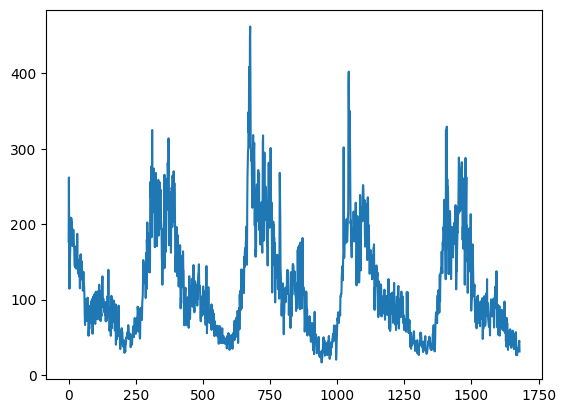

In [13]:
plt.plot(fitted_tbats)

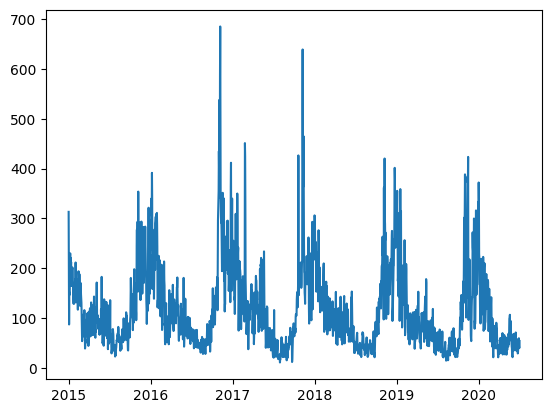

In [14]:
plt.plot(delhi_pm25)

In [167]:
# def preprocess( data: pd.Series, n_steps=5, labels=1):
#     lagged_values = np.concatenate([data.shift(n).values.reshape(-1,1) for n in range(n_steps,0,-1)],1)
#     lagged_values = lagged_values[~np.isnan(lagged_values).any(axis=1)]
        

    
#     output_values = data[n_steps:]
#     if labels!=1:
#         output_values = np.concatenate([output_values.shift(-n).values.reshape(-1,1) for n in range(0, labels)],1)
#         output_values = output_values[~np.isnan(output_values).any(axis=1)]
#     output_values = pd.DataFrame(output_values, index = data[n_steps:(len(data)-(labels-1))].index)
    
        
    
#     lagged_values = lagged_values[:output_values.shape[0],]

    
#     year_sin = np.sin((data[n_steps:(len(data)-(labels-1))].index).map(pd.Timestamp.timestamp) * (2 * np.pi/(24*60*60*365.2425)))
#     year_cos = np.cos((data[n_steps:(len(data)-(labels-1))].index).map(pd.Timestamp.timestamp) * (2 * np.pi/(24*60*60*365.2425)))

    
#     ds = pd.DataFrame(lagged_values, columns = ['lag_'+ str(i) for i in range(n_steps, 0, -1)])
#     ds.index = data[n_steps:(len(data)-(labels-1))].index
#     ds.loc[:,'year_sin'] = year_sin
#     ds.loc[:,'year_cos'] = year_cos
#     return (ds,output_values)

In [15]:
def preprocess( data: pd.Series, n_steps=7, labels=1, k_harmonics = 3):
    
    #Averages
    grouped = data.to_frame().reset_index()
    grouped = grouped.groupby(pd.Grouper(key = 'DT', freq = 'M')).mean().reset_index()

    grouped['last_month_avg'] = grouped['PM2.5'].shift(1)
    grouped['last_year_month_avg'] = grouped['PM2.5'].shift(12)

    grouped['month'] = grouped['DT'].dt.month
    grouped['year'] = grouped['DT'].dt.year

    #rolling_mean
    #do a rolling avg of week's worth concentration
    #we lag by a week, month, quarter and a year
    #since annual_seasonal, we give upon a year's worth of data 

    #23
    lookback = [1,362]
    
    rolling_mean = np.concatenate( [data.shift(i).rolling(7).mean().values.reshape(-1,1) for i in lookback],1)
    print(rolling_mean.shape)
    rolling_mean = rolling_mean[~np.isnan(rolling_mean).any(axis = 1)]

    cutoff_length = len(data) - len(rolling_mean)
    print(cutoff_length)
    
    #include lags around a year ago [362-369] (should only contain 7 elements)
    #include last month's avg, last year month's
     
    
    lagged_values = np.concatenate([data.shift(n).values.reshape(-1,1) for n in range(n_steps,0,-1)],1)
    lagged_values = lagged_values[~np.isnan(lagged_values).any(axis=1)]
    lagged_values = lagged_values[(cutoff_length-n_steps):,]
    


        

    #define output
    output_values = data[cutoff_length:]
    #if labels!=1:
     #   output_values = np.concatenate([output_values.shift(-n).values.reshape(-1,1) for n in range(0, labels)],1)
      #  output_values = output_values[~np.isnan(output_values).any(axis=1)]
    output_values = pd.DataFrame(output_values, index = data[cutoff_length:(len(data)-(labels-1))].index)
    
        
    #synchronizing
    lagged_values = lagged_values[:output_values.shape[0],]

    #date variables
    data_slice = data[cutoff_length:(len(data)-(labels-1))]
    day = data_slice.index.day_of_year.values
    week = data_slice.index.week.values
    year = data_slice.index.year.values
    month = data_slice.index.month.values
    quarter = data_slice.index.quarter.values

    
    fourier_terms = []
    fourier_term_index = []
    for i in range(1,k_harmonics+1):
        fourier_terms.append(np.sin((data_slice.index).map(pd.Timestamp.timestamp) * (i*2 * np.pi/(24*60*60*365.2425))))
        fourier_term_index.append('sin_'+str(i))
        fourier_terms.append(np.cos((data_slice.index).map(pd.Timestamp.timestamp) * (i*2 * np.pi/(24*60*60*365.2425))))
        fourier_term_index.append('cos_'+str(i))
    
    print("rolling_mean: \t", rolling_mean.shape, "\nlagged_values: \t", lagged_values.shape, "\noutput_values: \t", output_values.shape, "\ndata slice: \t", data_slice.shape)

    #putting it all together
    print(lagged_values.shape)
    print(output_values.shape)
    
    ds = pd.DataFrame(lagged_values, columns = ['lag_'+ str(i) for i in range(n_steps, 0, -1)])
    ds.index = data[cutoff_length:(len(data)-(labels-1))].index
    #ds.loc[:,'year_sin'] = year_sin
    #ds.loc[:,'year_cos'] = year_cos
    ds.loc[:,'day'] = day
    ds.loc[:,'week'] = week
    ds.loc[:,'year'] = year
    ds.loc[:,'month'] = month
    ds.loc[:,'quarter'] = quarter
    #ds = ds.merge(grouped[[ 'year', 'month', 'last_month_avg','last_year_month_avg']], on = ['year', 'month'], how = 'left')
    ds = ds.merge(grouped[[ 'year', 'month', 'last_year_month_avg']], on = ['year', 'month'], how = 'left')
    ds.loc[:,fourier_term_index] = np.array(fourier_terms).T

    for index, look in enumerate(lookback):
        ds.loc[:,'rolling_mean_'+str(look)] = rolling_mean[:,index]

    return (ds,output_values)

In [16]:
class RandomForestARModel():
    """
    Autoregressive Model
    """
    def __init__(self, max_depth= None, max_features = 1.0 , min_impurity_decrease = 0.0,
                 min_samples_split = 2, n_estimators=1000, random_state = 123, eta = 0.3, gamma = 0,
                reg_lambda = 1, model = 'RF') -> None:
        """
        """
        
        if model == 'RF':
            self.model = RandomForestRegressor(max_depth=max_depth, max_features = max_features,min_impurity_decrease = min_impurity_decrease,min_samples_split = min_samples_split,n_estimators = n_estimators, random_state = random_state)
    
        elif model == 'XG':
            self.model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth = max_depth, eta = eta, gamma = gamma,reg_lambda = reg_lambda, random_state = random_state)
        

    def fit(self, X_train, y_train):
        """
        """
        self.X_train = X_train
        self.y_train = y_train
        self.model.fit(X_train, y_train.values.reshape(-1)) 



    def in_sample_forecast(self, X_test, n_samples = 10000, random_seed=123):
        
        return(self.model.predict(X_test))
        
#         samples = []

        
#         np.random_seed = random_seed
#         for i in range(n_samples):
#             #the "1:" in Xf designates the shift
#             #the concat y is for the output
#             forecasts = []

#             for t in (X_test):
#                 tree = self.model.estimators_[np.random.randint(len(self.model.estimators_))]
#                 pred = tree.predict(t.reshape(1,-1))[0]
#                 forecasts.append(pred)

#             samples.append(forecasts)

#         return np.mean(samples, 0)

    
    def out_sample_forecast(self, X_test, n_steps, n_samples = 10000, random_seed=123):
        
        length = len(X_test)
        forecasts = []
        
        new_X = copy.deepcopy(X_test)
        
        for t in range(len(new_X)):
            #print("Loop: ", t)
            pred = self.model.predict(new_X.iloc[[t]])[0]
            forecasts.append(pred)
            if t < (length - 1):
                new_X.iloc[[t+1], :n_steps] =  new_X.iloc[[t], :n_steps].shift(-1, axis = 1).fillna(pred)
                #can be 13
                new_X.iloc[[t+1], (n_steps+12)] = new_X.iloc[t,(n_steps-7):n_steps].mean()

            
        return forecasts     
        
#         samples = []

#         np.random_seed = random_seed
#         for i in (range(n_samples)):
            
#             forecasts= []

#             for  t in (X_test_vars):
#                 test_vec = np.concatenate([init_vec, t])
#                 tree = self.model.estimators_[np.random.randint(len(self.model.estimators_))]
#                 pred = tree.predict(test_vec.reshape(1,-1))[0]
#                 forecasts.append(pred)
#                 init_vec = np.concatenate([init_vec[1:],np.array([pred])])
            
#             samples.append(forecasts)

#         return np.mean(samples, 0)

    def imp(self):
        xgb.plot_importance(self.model)



In [18]:
n_steps = 7

#normalize
scaler = MinMaxScaler()
scaler.fit(np.log(delhi_pm25).values.reshape(-1,1))
normed_vals = scaler.transform(np.log(delhi_pm25).values.reshape(-1,1))

normed = pd.Series(normed_vals.reshape(-1), index = delhi_pm25.index, name = 'PM2.5')

X,y = preprocess(normed, n_steps = n_steps)

X_train = X[:(int(0.8*len(X)))]
y_train = y[:(int(0.8*len(y)))]
X_test = X[(int(0.8*len(X))):]
y_test = y[(int(0.8*len(y))): ]


(2009, 2)
368
rolling_mean: 	 (1641, 2) 
lagged_values: 	 (1641, 7) 
output_values: 	 (1641, 1) 
data slice: 	 (1641,)
(1641, 7)
(1641, 1)


/var/folders/h2/sz1p61zn2sj13_34gp_3y3zm0000gn/T/ipykernel_6251/1742516560.py:54: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  week = data_slice.index.week.values


In [19]:
X_test.iloc[0,]

lag_7                     0.276950
lag_6                     0.282480
lag_5                     0.305372
lag_4                     0.351639
lag_3                     0.378586
lag_2                     0.245186
lag_1                     0.265158
day                     220.000000
week                     32.000000
year                   2019.000000
month                     8.000000
quarter                   3.000000
last_year_month_avg       0.307209
sin_1                    -0.587395
cos_1                    -0.809300
sin_2                     0.950758
cos_2                     0.309933
sin_3                    -0.951502
cos_3                     0.307642
rolling_mean_1            0.300767
rolling_mean_362          0.334406
Name: 1312, dtype: float64

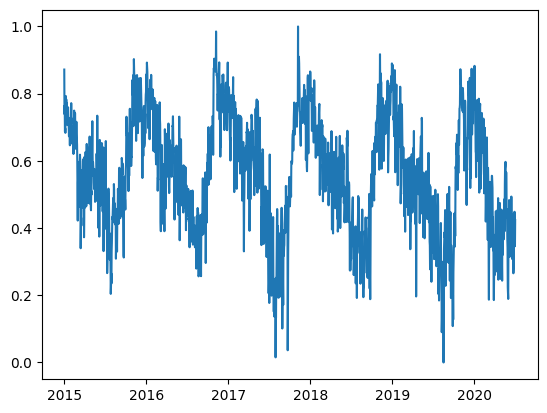

In [10]:
plt.plot(normed)

In [412]:
# rf = RandomForestARModel(model = 'RF')
# rf.fit(X_train, y_train)
# preds = rf.in_sample_forecast(X_test)
# plt.plot(y_test.index, y_test)
# plt.plot(preds)
# o_preds = rf.out_sample_forecast(X_test, n_steps)
# plt.plot(o_preds)
#del rf_xg
# rf_xg = RandomForestARModel(model='XG')
# rf_xg.fit(X_train, y_train)

# preds_Xg = rf_xg.in_sample_forecast(X_test)
# plt.plot(preds_Xg)

# o_preds_Xg = rf_xg.out_sample_forecast(X_test, n_steps)
# plt.plot(o_preds_Xg)
#plt.legend(preds_Xg, o_preds_Xg)
#plt.show()
#print('RF_in: \t', mean_squared_error(preds, y_test, squared = False), '\nRF_out: \t', mean_squared_error(o_preds, y_test, squared = False), '\nXG_in: \t', mean_squared_error(preds_Xg, y_test, squared = False), '\nXG_out: \t', mean_squared_error(o_preds_Xg, y_test, squared = False))
#print('RF_in: \t', mean_squared_error(preds, y_test, squared = False), '\nRF_out: \t', mean_squared_error(o_preds, y_test, squared = False), '\nXG_in: \t', mean_squared_error(preds_Xg, y_test, squared = False), '\nXG_out: \t', mean_squared_error(o_preds_Xg, y_test, squared = False))
#rf_xg.imp()
# plt.plot(np.exp(scaler.inverse_transform(preds.reshape(-1,1))))
# plt.plot(np.exp(scaler.inverse_transform(np.array(o_preds).reshape(-1,1))))
# plt.plot(delhi_pm25[-329:])
# mean_squared_error((np.exp(scaler.inverse_transform(np.array(y_test).reshape(-1,1)))), (np.exp(scaler.inverse_transform(np.array(o_preds2).reshape(-1,1)))), squared = False)
# mean_squared_error(fitted_rf, (np.exp(scaler.inverse_transform(np.array(y_train).reshape(-1,1)))), squared = False)
# plt.figure(figsize=(15,4))
# residu = ((rf.in_sample_forecast(X_train))).reshape(-1) - y_train.values.reshape(-1)
# plt.plot(residu)
#plt.plot(((scaler.inverse_transform((rf.in_sample_forecast(X_train)).reshape(-1,1)))).reshape(-1) - np.log(delhi_pm25[368:-329]))

# rcParams['figure.figsize'] = 15, 4
# fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,6))

# plot_acf((residu), lags = 15 , ax = ax1, color = 'crimson')
# ax1.set_title('ACF Plot')
# ax1.set_ylim(-0.1,1)

# plot_pacf((residu)**2, lags = 15, ax = ax2, color = 'crimson')
# ax2.set_ylim(-0.2,1)

# ax2.set_xlabel('Lags')

# fig.tight_layout()


# plt.show()
# np.mean(residu)
# plt.hist(delhi_pm25)
# (np.exp(scaler.inverse_transform(preds.reshape(-1,1))))







In [24]:
# def k_fold_score(model, X, y, n_folds):
    
#     X,y = X.values,y.values
#     strat_kfold = cross(n_splits=n_folds, shuffle=True, random_state=1)
#     accuracy_list = []
#     for train_index, test_index in strat_kfold.split(X, y):
#         x_train_fold, x_test_fold = X[train_index], X[test_index]
#         y_train_fold, y_test_fold = y[train_index], y[test_index]
#         model.fit(x_train_fold, y_train_fold)
#         preds = model.predict(x_test_fold)
        
#         #introduce rmse error
#         accuracy_test = mean_squared_error(preds,y_test_fold, squared=False)
#         accuracy_list.append(accuracy_test)

    
#     return np.array(accuracy_list).mean()

def optimizer(max_depth, min_samples_split, min_impurity_decrease, n_estimators, max_features):
    params = {
    'max_depth': int(max_depth),
    'min_samples_split': int(min_samples_split),
    'min_impurity_decrease': min_impurity_decrease,
    'n_estimators': int(n_estimators),
    'max_features': max_features
}
    n_folds = 5

    model = RandomForestRegressor(max_depth= params['max_depth'], min_samples_split = params['min_samples_split'] ,
                                  min_impurity_decrease = params['min_impurity_decrease'],
                                  n_estimators = params['n_estimators'],
                                  max_features = params['max_features'],
                                  random_state = 123)
    
    scores = cross_val_score(model, X, y.values.reshape(-1,), cv=n_folds, scoring = 'neg_root_mean_squared_error')

    return scores.mean()

params = {
    'max_depth':(3,10),
    'min_samples_split':(2,10),
    'min_impurity_decrease':(0, 1e-5),
    'n_estimators':(100,1000),
    'max_features':(0.5, 1)
}




In [67]:
bo = BayesianOptimization(optimizer, params)
results = bo.maximize(n_iter=200)


|   iter    |  target   | max_depth | max_fe... | min_im... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | 0.8073    | 9.81      | 0.9888    | 8.986e-07 | 5.597     | 325.2     |
| 2         | 0.8077    | 2.702     | 0.5514    | 6.029e-06 | 6.61      | 638.4     |
| 3         | 0.8091    | 4.99      | 0.5344    | 5.982e-06 | 4.602     | 164.5     |
| 4         | 0.8076    | 5.45      | 0.6787    | 8.283e-06 | 3.34      | 580.6     |
| 5         | 0.8077    | 1.27      | 0.5035    | 1.593e-06 | 8.427     | 368.7     |
| 6         | 0.8078    | 5.25      | 0.8528    | 9.997e-06 | 5.214     | 163.8     |
| 7         | 0.8077    | 4.712     | 0.8741    | 4.619e-06 | 5.396     | 978.7     |
| 8         | 0.8062    | 7.635     | 0.8981    | 5.849e-06 | 6.086     | 217.8     |
| 9         | 0.8089    | 4.524     | 0.8671    | 6.928e-06 | 4.974     | 165.1     |
| 10        | 0.8086    | 3.748     | 0.6824    | 6.45

| 58        | 0.8092    | 3.604     | 0.6902    | 4.895e-06 | 9.914     | 823.2     |
| 59        | 0.8073    | 6.38      | 0.7914    | 7.931e-06 | 9.687     | 572.3     |
| 60        | 0.8096    | 6.379     | 0.6137    | 1.767e-06 | 7.33      | 668.4     |
| 61        | 0.8084    | 1.793     | 0.7959    | 2.118e-06 | 4.254     | 892.4     |
| 62        | 0.8072    | 3.821     | 0.7704    | 6.414e-06 | 8.724     | 708.3     |
| 63        | 0.8074    | 1.073     | 0.953     | 9.506e-06 | 4.117     | 785.1     |
| 64        | 0.8095    | 6.884     | 0.8824    | 5.674e-06 | 3.26      | 218.7     |
| 65        | 0.8081    | 7.241     | 0.7688    | 1.495e-06 | 4.019     | 536.4     |
| 66        | 0.8087    | 2.06      | 0.5285    | 4.317e-06 | 4.524     | 988.2     |
| 67        | 0.8103    | 4.813     | 0.6273    | 9.572e-06 | 9.075     | 618.1     |
| 68        | 0.811     | 1.237     | 0.8749    | 5.48e-06  | 4.752     | 471.4     |
| 69        | 0.8077    | 7.971     | 0.7059    | 3.30

| 116       | 0.8065    | 9.193     | 0.8305    | 5.418e-06 | 6.142     | 615.9     |
| 117       | 0.8076    | 3.87      | 0.9642    | 5.909e-06 | 7.127     | 720.5     |
| 118       | 0.8094    | 7.575     | 0.5821    | 6.673e-07 | 3.2       | 951.6     |
| 119       | 0.8077    | 6.118     | 0.9261    | 3.633e-06 | 7.757     | 542.7     |
| 120       | 0.8092    | 2.092     | 0.5585    | 7.939e-06 | 8.409     | 671.1     |
| 121       | 0.8065    | 5.964     | 0.6567    | 2.569e-08 | 3.514     | 960.3     |
| 122       | 0.8093    | 3.809     | 0.5522    | 3.697e-06 | 2.213     | 128.3     |
| 123       | 0.8083    | 8.988     | 0.6817    | 6.596e-06 | 9.645     | 352.5     |
| 124       | 0.8052    | 4.562     | 0.58      | 7.935e-06 | 9.616     | 991.3     |
| 125       | 0.8075    | 2.759     | 0.6332    | 5.307e-06 | 9.562     | 196.3     |
| 126       | 0.8098    | 5.98      | 0.8695    | 3.102e-06 | 7.547     | 740.8     |
| 127       | 0.8093    | 4.459     | 0.6061    | 3.00

| 174       | 0.808     | 8.261     | 0.6365    | 9.869e-06 | 8.705     | 361.2     |
| 175       | 0.8097    | 4.584     | 0.8121    | 9.821e-06 | 3.572     | 686.8     |
| 176       | 0.8088    | 2.996     | 0.8446    | 7.804e-06 | 5.012     | 339.1     |
| 177       | 0.8085    | 4.567     | 0.7821    | 6.021e-06 | 6.597     | 938.1     |
| 178       | 0.8094    | 1.067     | 0.8503    | 6.933e-06 | 8.591     | 788.9     |
| 179       | 0.808     | 7.971     | 0.731     | 1.038e-06 | 7.24      | 584.0     |
| 180       | 0.8073    | 8.253     | 0.6224    | 4.439e-06 | 8.293     | 874.8     |
| 181       | 0.8066    | 3.138     | 0.8726    | 2.095e-06 | 4.959     | 508.3     |
| 182       | 0.8074    | 1.482     | 0.6439    | 2.173e-06 | 7.719     | 100.8     |
| 183       | 0.8055    | 9.332     | 0.5098    | 2.779e-06 | 3.4       | 339.3     |
| 184       | 0.8083    | 6.258     | 0.7285    | 6.556e-06 | 4.808     | 656.5     |
| 185       | 0.8073    | 5.239     | 0.7007    | 1.89

In [71]:
bo.max  #R^2

{'target': 0.8115158669080212,
 'params': {'max_depth': 5.2340511498119415,
  'max_features': 0.8721259535500586,
  'min_impurity_decrease': 4.360847729065543e-06,
  'min_samples_split': 5.900055286679918,
  'n_estimators': 432.34912175229147}}

In [26]:
bo2 = BayesianOptimization(optimizer, params, verbose = 0)  #for RMSE
bo2.maximize(n_iter=200)

In [27]:
opti_param = bo2.max['params']
opti_param['max_depth'] = int(opti_param['max_depth'])
opti_param['min_samples_split'] = int(opti_param['min_samples_split'])
opti_param['n_estimators'] = int(opti_param['n_estimators'])
opti_param

{'max_depth': 5,
 'max_features': 0.859618841238565,
 'min_impurity_decrease': 1.4097449617976766e-07,
 'min_samples_split': 9,
 'n_estimators': 545}

In [44]:
rf2 = RandomForestARModel(max_depth = 8, max_features= 0.859618841238565, min_samples_split = 9, min_impurity_decrease = 1.4097449617976766e-07, n_estimators = 545, model = 'RF')
rf2.fit(X_train, y_train)

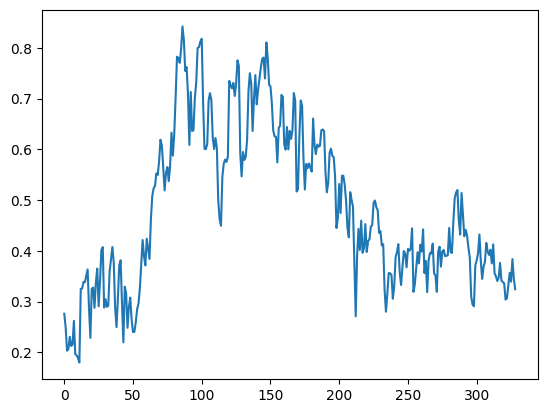

In [29]:
preds2 = rf2.in_sample_forecast(X_test)
plt.plot(preds2)

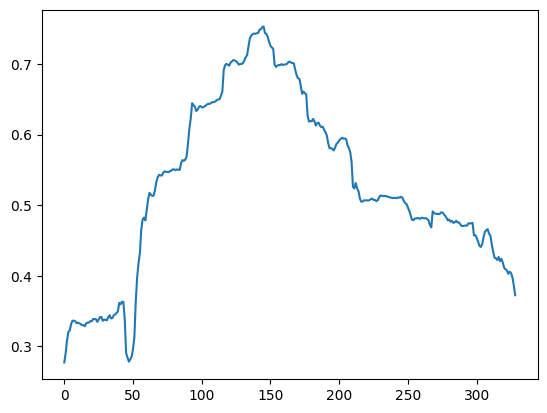

In [45]:
o_preds2 = rf2.out_sample_forecast(X_test, n_steps)
plt.plot(o_preds2)

### RMSE

In [46]:
mean_squared_error((np.exp(scaler.inverse_transform(np.array(y_test).reshape(-1,1)))), (np.exp(scaler.inverse_transform(np.array(o_preds2).reshape(-1,1)))), squared = False)

59.409426875516765

In [54]:
(scaler.inverse_transform(rf2.in_sample_forecast(X_train).reshape(-1,1)) - scaler.inverse_transform(y_train.values.reshape(-1,1))).mean()

-0.0014527543535338768

In [139]:
#plt.plot(((rf2.in_sample_forecast(X_train))).reshape(-1) - y_train.values.reshape(-1))

In [47]:
def xg_optimizer(eta, reg_lambda, max_depth, gamma, n_estimators):
    params = {
    'max_depth': int(max_depth),
    'reg_lambda': int(reg_lambda),
    'gamma': gamma,
    'n_estimators': int(n_estimators),
    'eta': eta
}
    n_folds = 5


    modell = xgb.XGBRegressor(max_depth= params['max_depth'],
                                  gamma = params['gamma'],
                                  n_estimators = params['n_estimators'],
                              eta = params['eta'],
                              reg_lambda = params['reg_lambda'],
                              
                                  random_state = 123)
    
    scores = cross_val_score(modell, X, y.values.reshape(-1,), cv=n_folds, scoring = 'neg_root_mean_squared_error')

    return scores.mean()

params = {
    'eta' : (0,0.1),
    'reg_lambda' : (1,5),
    'max_depth':(3,10),
    'gamma':(0, 1e-5),
    'n_estimators':(100,1000)
}

bo2 = BayesianOptimization(xg_optimizer, params, verbose = 0)  #for RMSE
bo2.maximize(n_iter=200)

In [48]:
bo2.max

{'target': -0.07192697795499989,
 'params': {'eta': 0.012154950900704077,
  'gamma': 1.9664668051979574e-06,
  'max_depth': 3.68440526425692,
  'n_estimators': 661.4079725493172,
  'reg_lambda': 1.412874162709783}}

In [50]:
xg_rf2 = RandomForestARModel(max_depth = 4, eta= 0.022253223445268134, gamma = 7.584460192040908e-06, reg_lambda = 2.521292191740957, n_estimators = 301, model = 'XG')
xg_rf2.fit(X_train, y_train)

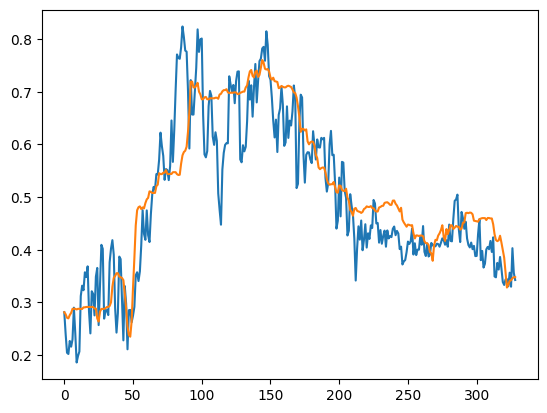

In [51]:


preds_Xg2 = xg_rf2.in_sample_forecast(X_test)
plt.plot(preds_Xg2)

o_preds_Xg2 = xg_rf2.out_sample_forecast(X_test, n_steps)
plt.plot(o_preds_Xg2)
#plt.legend(preds_Xg, o_preds_Xg)
plt.show()


In [338]:
print('RF_opti_in: \t', mean_squared_error(preds2, y_test, squared = False), '\nRF_opti_out: \t', mean_squared_error(o_preds2, y_test, squared = False), '\nXG_opti_in: \t', mean_squared_error(preds_Xg2, y_test, squared = False), '\nXG_opti_out: \t', mean_squared_error(o_preds_Xg2, y_test, squared = False))

RF_opti_in: 	 0.07808656480699466 
RF_opti_out: 	 0.1325879866333217 
XG_opti_in: 	 0.08303408910512479 
XG_opti_out: 	 0.12927341324915673


In [108]:
mean_squared_error((np.exp(scaler.inverse_transform(np.array(y_test).reshape(-1,1)))), (np.exp(scaler.inverse_transform(np.array(o_preds2).reshape(-1,1)))), squared = False)

59.409426875516765

In [113]:
mean_squared_error((np.exp(scaler.inverse_transform(np.array(y_test).reshape(-1,1)))), forecast_tbats, squared = False)

54.7537005153939

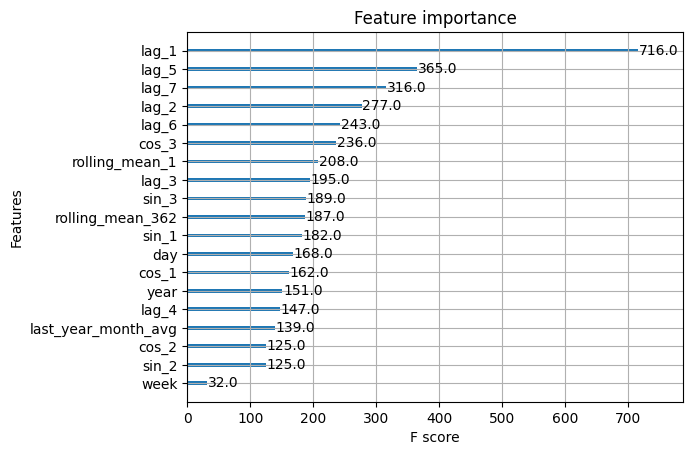

In [54]:
xg_rf2.imp()

Text(0.5, 1.0, 'Residual Plot for XG')

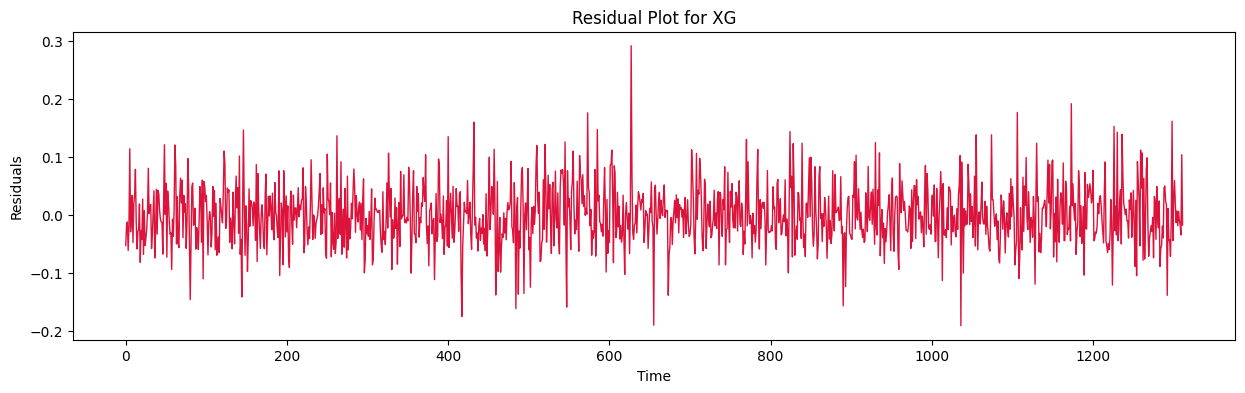

In [55]:
plt.figure(figsize=(15,4))
residu = ((xg_rf2.in_sample_forecast(X_train))).reshape(-1) - y_train.values.reshape(-1)
plt.plot(residu, linewidth=1, color= 'crimson')
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.title("Residual Plot for XG")

#plt.plot(((scaler.inverse_transform((rf.in_sample_forecast(X_train)).reshape(-1,1)))).reshape(-1) - np.log(delhi_pm25[368:-329]))

/Users/rahulsingh/miniconda3/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


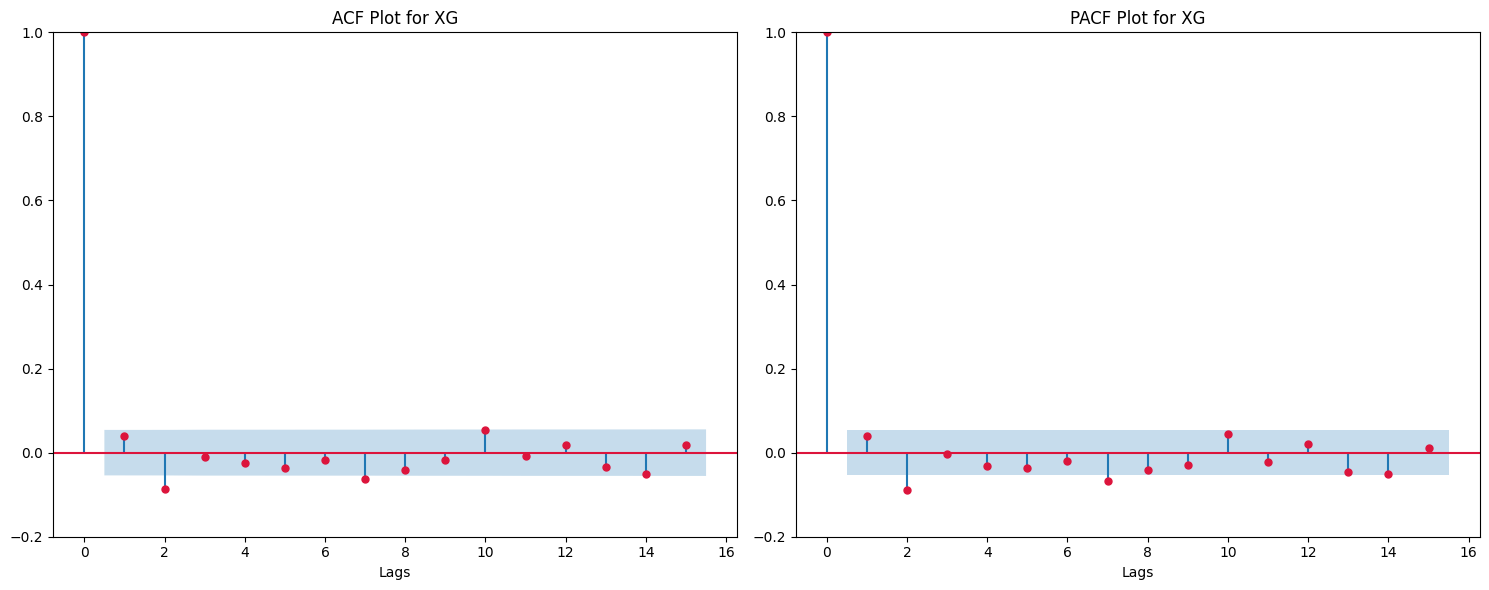

In [57]:
rcParams['figure.figsize'] = 15, 4
fig, (ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,6))
residu = ((xg_rf2.in_sample_forecast(X_train))).reshape(-1) - y_train.values.reshape(-1)

plot_acf((residu), lags = 15 , ax = ax1, color = 'crimson')
ax1.set_title('ACF Plot for XG')
#ax1.tick_params(labelbottom = False, bottom = False )
ax1.set_ylim(-0.2,1)
ax1.set_xlabel('Lags')

plot_pacf((residu), lags = 15, ax = ax2, color = 'crimson')
ax2.set_title('PACF Plot for XG')
ax2.set_ylim(-0.2,1)

ax2.set_xlabel('Lags')

fig.tight_layout()

# show the plot
plt.show()



In [58]:
(rf2.in_sample_forecast(X_train).reshape(-1) - y_train.values.reshape(-1)).mean()

-0.00018845065731370946

In [59]:
resids = (xg_rf2.in_sample_forecast(X_train).reshape(-1) - y_train.values.reshape(-1))

from scipy import stats
res = stats.shapiro(resids)
res.statistic

0.9857702255249023

In [60]:
res = stats.shapiro(resids_tbats)
res.statistic

0.9847460985183716

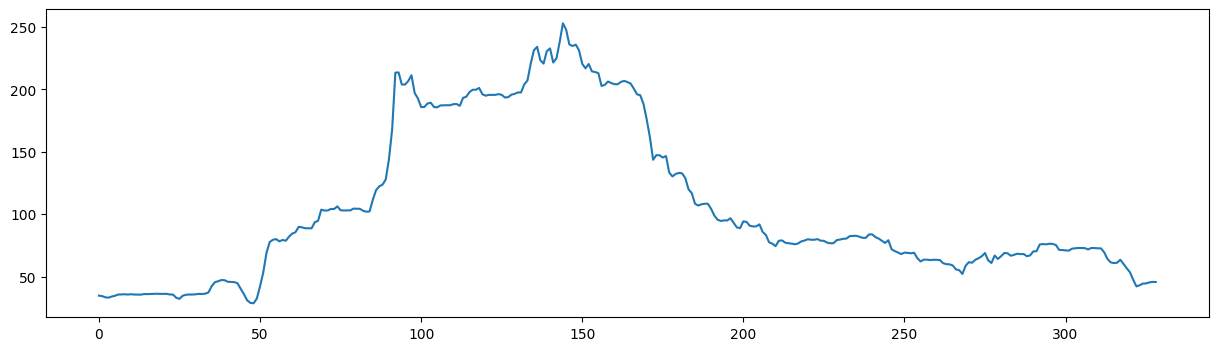

In [61]:
plt.plot(np.exp(scaler.inverse_transform(np.array(o_preds_Xg2).reshape(-1,1))).reshape(-1) - y_test.values.reshape(-1))
#year_test = pd.concat([X_train.iloc[-36:,],X_test])
#plt.plot(rf2.out_sample_forecast(year_test, n_steps))
#year_test = pd.concat([X_train.iloc[-36:,],X_test])
#plt.plot(xg_rf2.out_sample_forecast(year_test, n_steps))
#plt.plot(pd.concat([y_train.iloc[-36:,], y_test]))

In [62]:
fitted_xg = np.exp(scaler.inverse_transform(xg_rf2.in_sample_forecast(X_train).reshape(-1,1))).reshape(-1)
fitted_rf = np.exp(scaler.inverse_transform(rf2.in_sample_forecast(X_train).reshape(-1,1))).reshape(-1)   
forecast_xg = (((np.exp(scaler.inverse_transform(np.array(o_preds_Xg2).reshape(-1,1))).reshape(-1))))
forecast_rf = (((np.exp(scaler.inverse_transform(np.array(o_preds2).reshape(-1,1))).reshape(-1))))


In [63]:
entire_rf = np.concatenate([fitted_rf,forecast_rf]).tolist()
entire_xg = np.concatenate([fitted_xg,forecast_xg]).tolist()
entire_tbats = np.concatenate([fitted_tbats, forecast_tbats]).tolist()
entire_dhr = np.concatenate([fitted_dhr, forecast_tbats]).tolist()
entire_gam = np.concatenate([fitted_gam, forecast_tbats]).tolist()

In [132]:
mean_squared_error((np.exp(scaler.inverse_transform(np.array(y_train).reshape(-1,1)))).reshape(-1),fitted_rf,squared=False)

27.543815598001256

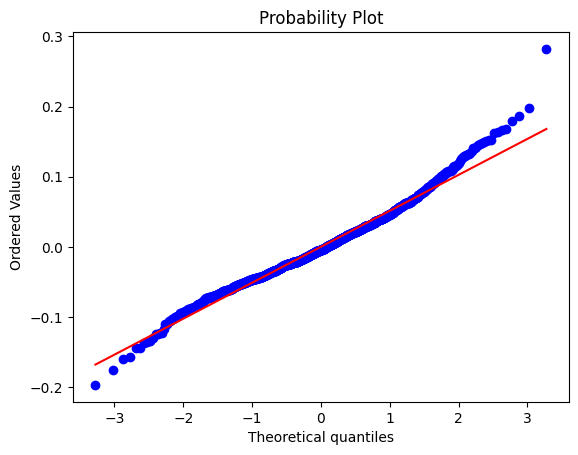

In [352]:
stats.probplot((xg_rf2.in_sample_forecast(X_train).reshape(-1) - y_train.values.reshape(-1)).tolist(), plot = plt)
plt.show()

# LSTM

In [64]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from tensorflow.keras.applications import EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3, EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
import keras_tuner as kt
import tensorflow_datasets as tfds

In [65]:
%load_ext rpy2.ipython
%R library(forecast)
%R library(TSA)
%R library(ggplot2)

%R calls = read.csv("out.csv", header = T)
%R myts <- ts((calls), frequency=365)

# %R -i delhi_pm25
# %R myts <- ts((delhi_pm25), frequency=365)

%R fourier_terms = fourier(myts, K = 4)
%R model <- auto.arima(myts, xreg=fourier_terms, seasonal=FALSE, lambda=0)
%R seas_comp = ((fourier_terms[,1]*(model$coef)[4]) + (fourier_terms[,2]*(model$coef)[5]) + (fourier_terms[,3]*(model$coef)[6]) + (fourier_terms[,4]*(model$coef)[7]) + (fourier_terms[,5]*(model$coef)[8]) + (fourier_terms[,6]*(model$coef)[9]) + (fourier_terms[,7]*(model$coef)[10]) + (fourier_terms[,8]*(model$coef)[11]))
%R -o seas_comp

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


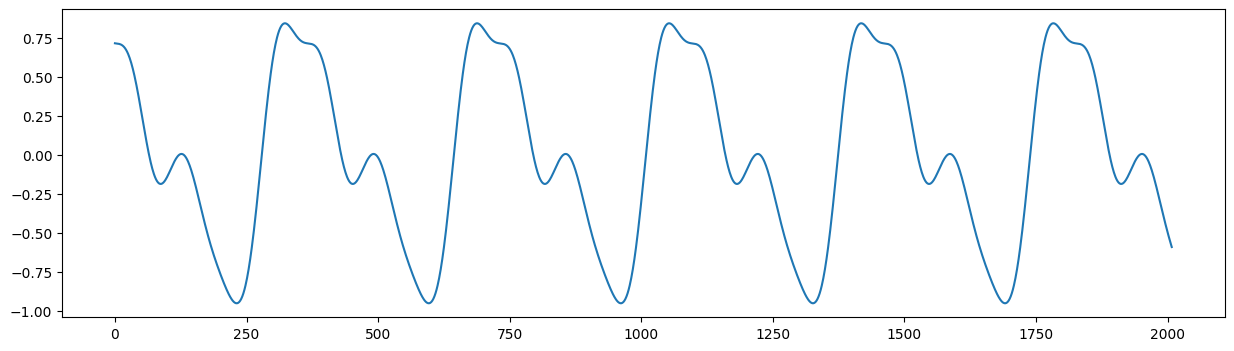

In [66]:
plt.plot(seas_comp)

In [67]:
def make_dataset(data, n_steps, labels, batch_size = 50):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
      data = data,
      targets = None,
      sequence_length = n_steps+labels,
      sequence_stride = 1,
      shuffle = False #,
      #batch_size = batch_size
    )
    
    input_slice = slice(0, n_steps)
    labels_slice = slice(n_steps, n_steps+labels)
    
    
    ds = ds.map(lambda x: (x[:,input_slice,:], x[:,labels_slice,:]))
    #ds = ds.map(lambda x: (x[:,input_slice,:].set_shape([None,n_steps,None]),x[:,labels_slice,:].set_shape([None,labels,None])))
    return ds

In [68]:
#deas = np.log(delhi_pm25)
deas = np.log(delhi_pm25) - seas_comp
length = len(delhi_pm25)
deas = deas.values.reshape(-1,1)
train_set = deas[:int(0.7 * length)]
valid_set = deas[int(0.7 * length): (length-(329+7))]
test_set = deas[(length-(329+7)): ]

n_steps = 7
label_size = 1
train_set = make_dataset(train_set, n_steps, label_size)
valid_set = make_dataset(valid_set, n_steps, label_size)
test_set = make_dataset(test_set, n_steps, label_size)

Metal device set to: Apple M1 Pro


In [71]:
def model_builder(hp):
    model = tf.keras.models.Sequential()


    hp_units = hp.Int('units', min_value=20, max_value=50)
    model.add(tf.keras.layers.LSTM(units=hp_units, return_sequences=True))
    
    hp_units2 = hp.Int('units2', min_value=20, max_value=50)
    model.add(tf.keras.layers.LSTM(units=hp_units2))
    
    model.add(tf.keras.layers.Dense(1))

    hp_learning_rate = hp.Float('learning_rate', min_value = 1e-3, max_value = 1e-1, step = 10)
    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate),
                metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])



    return model

tuner = kt.Hyperband(model_builder,
                     objective='val_mean_absolute_percentage_error',
                     max_epochs=50,
                     overwrite=True,
                     factor=3)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


In [72]:
tuner.search(train_set, epochs=50, validation_data=valid_set, callbacks=[stop_early])
    
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 90 Complete [00h 00m 14s]
val_mean_absolute_percentage_error: 6.245560169219971

Best val_mean_absolute_percentage_error So Far: 6.2231125831604
Total elapsed time: 00h 14m 25s
INFO:tensorflow:Oracle triggered exit


In [73]:
print(best_hps.get('learning_rate'), best_hps.get('units'), best_hps.get('units2')) #15 window size, prediction size 1

0.001 41 23


In [74]:

MAX_EPOCHS = 100

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=5,
                                                    mode='min')
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(44, return_sequences=True),
    tf.keras.layers.LSTM(23),
    tf.keras.layers.Dense(label_size)
])

model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = 0.001),
                metrics=[tf.keras.metrics.MeanAbsolutePercentageError()])

history = model.fit(train_set, epochs=MAX_EPOCHS,
                      validation_data=valid_set,
                      callbacks=[early_stopping])

Epoch 1/100
11/11 [==============================] - 9s 484ms/step - loss: 14.8904 - mean_absolute_percentage_error: 82.6055 - val_loss: 8.6115 - val_mean_absolute_percentage_error: 64.7277
Epoch 2/100
11/11 [==============================] - 1s 119ms/step - loss: 5.7494 - mean_absolute_percentage_error: 49.9281 - val_loss: 1.9171 - val_mean_absolute_percentage_error: 29.4783
Epoch 3/100
11/11 [==============================] - 1s 87ms/step - loss: 0.9515 - mean_absolute_percentage_error: 17.7628 - val_loss: 0.1178 - val_mean_absolute_percentage_error: 6.2830
Epoch 4/100
11/11 [==============================] - 1s 76ms/step - loss: 0.1861 - mean_absolute_percentage_error: 7.6714 - val_loss: 0.3341 - val_mean_absolute_percentage_error: 11.4450
Epoch 5/100
11/11 [==============================] - 0s 29ms/step - loss: 0.2146 - mean_absolute_percentage_error: 8.5473 - val_loss: 0.2109 - val_mean_absolute_percentage_error: 8.7850
Epoch 6/100
11/11 [==============================] - 0s 39ms/

In [75]:
iterator = test_set.__iter__()
test_vec = np.empty(shape=(0,7))
for i in range(int(np.ceil(329/128))):
    next_element = iterator.get_next()
    test_vec = np.concatenate([test_vec, next_element[0].numpy().reshape(next_element[0].numpy().shape[0],7)])

# iterator = test_set.__iter__()
# next_element = iterator.get_next()
# test_vec = next_element[0].numpy()[0].reshape(-1,7)

In [76]:
test_vec.shape

(329, 7)

In [77]:
res = model.predict(test_set)

3/3 [==============================] - 2s 184ms/step


In [78]:
test_vec[:5]

array([[4.40355539, 4.433846  , 4.53586578, 4.73450708, 4.85284853,
        4.30652666, 4.39540243],
       [4.433846  , 4.53586578, 4.73450708, 4.85284853, 4.30652666,
        4.39540243, 4.23697186],
       [4.53586578, 4.73450708, 4.85284853, 4.30652666, 4.39540243,
        4.23697186, 3.60198069],
       [4.73450708, 4.85284853, 4.30652666, 4.39540243, 4.23697186,
        3.60198069, 3.74370432],
       [4.85284853, 4.30652666, 4.39540243, 4.23697186, 3.60198069,
        3.74370432, 4.17132664]])

In [79]:
def shift1(arr, num, fill_value=np.nan):
    arr = np.roll(arr,num)
    if num < 0:
        arr[num:] = fill_value
    elif num > 0:
        arr[:num] = fill_value
    return arr

In [80]:
result_lstm = []
for index, element in enumerate(test_vec):
    step_pred = model.predict(element.reshape(1,7), verbose = False)
    result_lstm.append(step_pred.flatten()[0])
    if index < 328:
        test_vec[index+1] = shift1(test_vec[index],-1,step_pred.flatten()[0])

In [81]:
test_vec[:5]

array([[4.40355539, 4.433846  , 4.53586578, 4.73450708, 4.85284853,
        4.30652666, 4.39540243],
       [4.433846  , 4.53586578, 4.73450708, 4.85284853, 4.30652666,
        4.39540243, 4.58621693],
       [4.53586578, 4.73450708, 4.85284853, 4.30652666, 4.39540243,
        4.58621693, 4.58762217],
       [4.73450708, 4.85284853, 4.30652666, 4.39540243, 4.58621693,
        4.58762217, 4.59040976],
       [4.85284853, 4.30652666, 4.39540243, 4.58621693, 4.58762217,
        4.59040976, 4.59186363]])

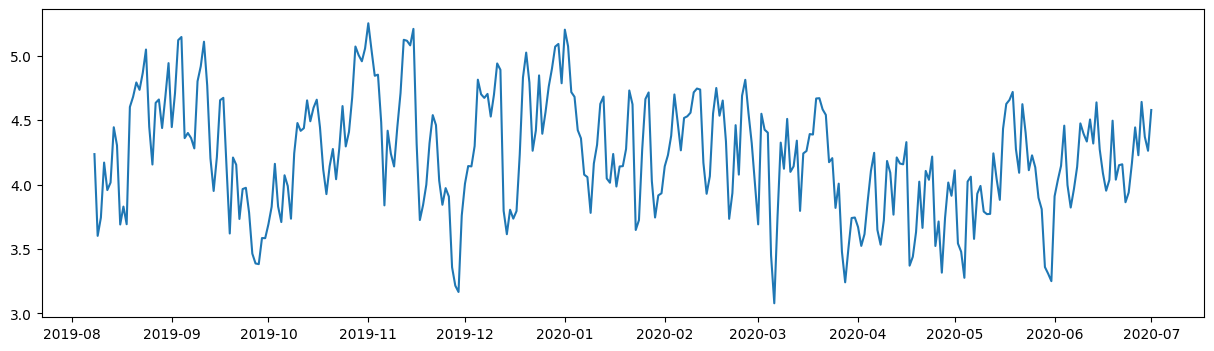

In [82]:
plt.plot(delhi_pm25[(length-329): ].index, (np.log(delhi_pm25[ (length - 329): ])- seas_comp[int(length-329):]))

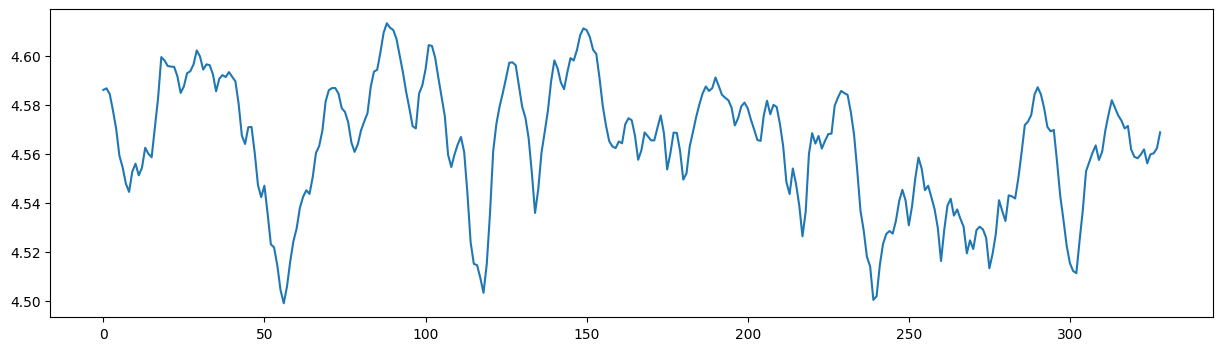

In [83]:
plt.plot(res)

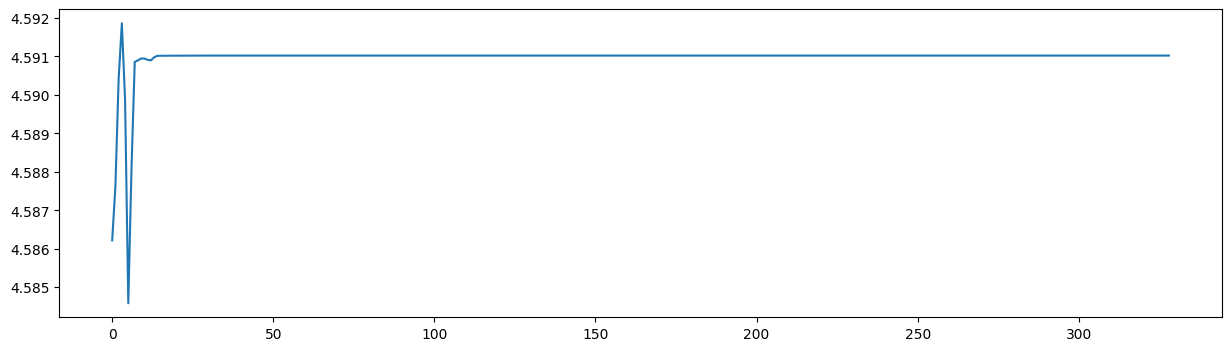

In [84]:
plt.plot(result_lstm)

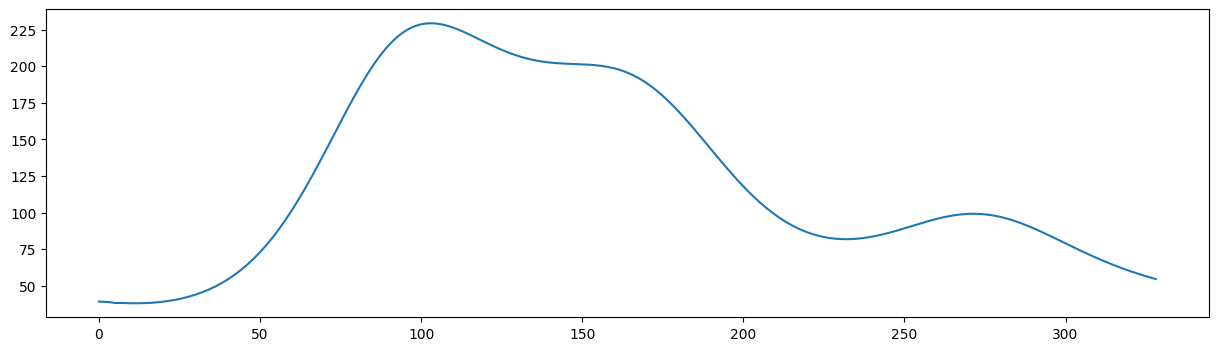

In [85]:
#plt.plot(np.exp((seas_comp[(length-329): ]) + (res.reshape(-1))))
forecast_lstm = np.exp((seas_comp[(length-329): ]) + result_lstm )
plt.plot(forecast_lstm)

In [86]:
fitted_lstm = model.predict(train_set)

11/11 [==============================] - 1s 38ms/step


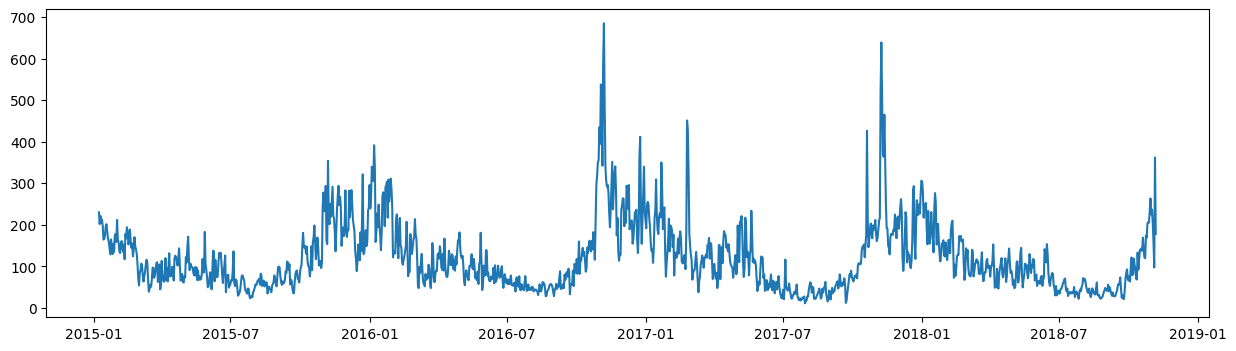

In [87]:
plt.plot(delhi_pm25[7:(fitted_lstm.shape[0]+7)])

In [88]:
#plt.plot(fitted_lstm)
#plt.plot(( deas[7:(fitted_lstm.shape[0]+7)].reshape(-1)  ))
resids_lstm = (( deas[7:(fitted_lstm.shape[0]+7)].reshape(-1)) - (fitted_lstm).reshape(-1))

In [89]:
delhi_pm25[7:(fitted_lstm.shape[0]+7)].shape

(1399,)

In [90]:
#plt.plot(np.exp((seas_comp[7:(fitted_lstm.shape[0]+7)]) + deas[7:(fitted_lstm.shape[0]+7)].reshape(-1)  ))
fitted_lstm = model.predict(train_set)
fitted_lstm = (np.exp((seas_comp[7:(fitted_lstm.shape[0]+7)]) + fitted_lstm.reshape(-1)  ))

11/11 [==============================] - 0s 8ms/step


In [114]:
mean_squared_error(fitted_lstm, delhi_pm25[7:(fitted_lstm.shape[0]+7)], squared = False)

50.95981553952318

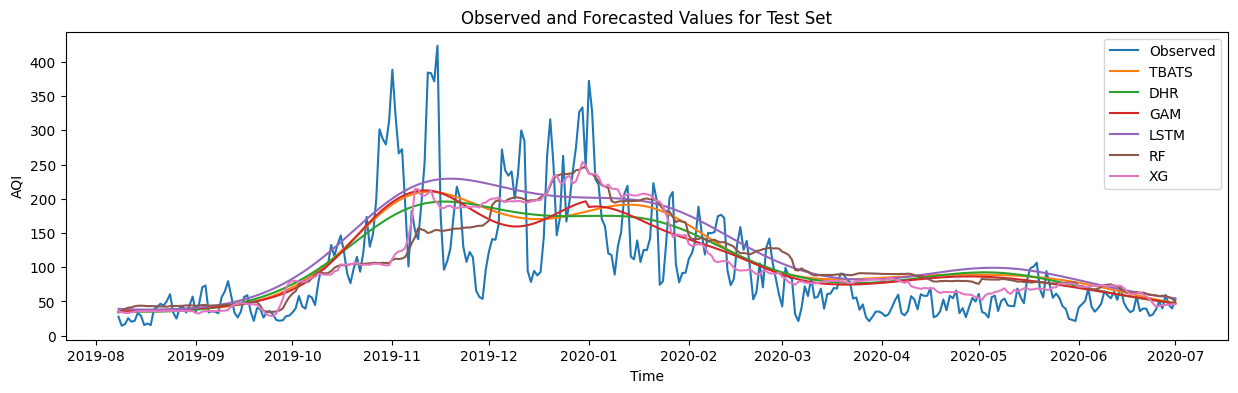

In [92]:
#colors = sns.color_palette("RdBu", n_colors=7)
#plt.gca().set_color_cycle(colors)

plt.plot(delhi_pm25[-329:])
plt.plot(delhi_pm25[-329:].index, forecast_tbats)
plt.plot(delhi_pm25[-329:].index, forecast_dhr)
plt.plot(delhi_pm25[-329:].index, forecast_gam)
plt.plot(delhi_pm25[-329:].index, forecast_lstm)
plt.plot(delhi_pm25[-329:].index, forecast_rf)
plt.plot(delhi_pm25[-329:].index, forecast_xg)
plt.xlabel("Time")
plt.ylabel("AQI")
plt.title("Observed and Forecasted Values for Test Set")
plt.legend(['Observed','TBATS','DHR','GAM','LSTM','RF','XG'])

In [93]:
results = pd.DataFrame(delhi_pm25.iloc[-329:],columns=['Observed'])
results[['TBATS','DHR','GAM','RF','XG','LSTM']] = np.array([forecast_tbats,forecast_dhr, forecast_gam, forecast_rf,forecast_xg, forecast_lstm]).T

In [94]:
results

,Observed,TBATS,DHR,GAM,RF,XG,LSTM
DT,,,,,,,
2019-08-08,27.685417,35.222684,34.184801,35.201192,34.285491,34.906219,39.257829
2019-08-09,14.591667,35.463530,34.669727,35.314816,36.194683,34.348297,39.098815
2019-08-10,16.727917,36.091139,34.876061,35.333209,38.998387,33.410458,39.008685
2019-08-11,25.533750,36.271541,34.946447,35.591341,41.011907,33.257660,38.882263
2019-08-12,20.531250,36.459561,34.955612,35.842785,41.369664,34.134407,38.639013
...,...,...,...,...,...,...,...
2020-06-27,39.804583,51.095715,50.010201,49.839030,58.426595,44.650448,57.213152
2020-06-28,59.522500,50.200905,49.401668,49.083434,57.924416,44.884003,56.540026
2020-06-29,44.861667,49.333187,48.810098,48.327542,56.507956,45.632069,55.884909


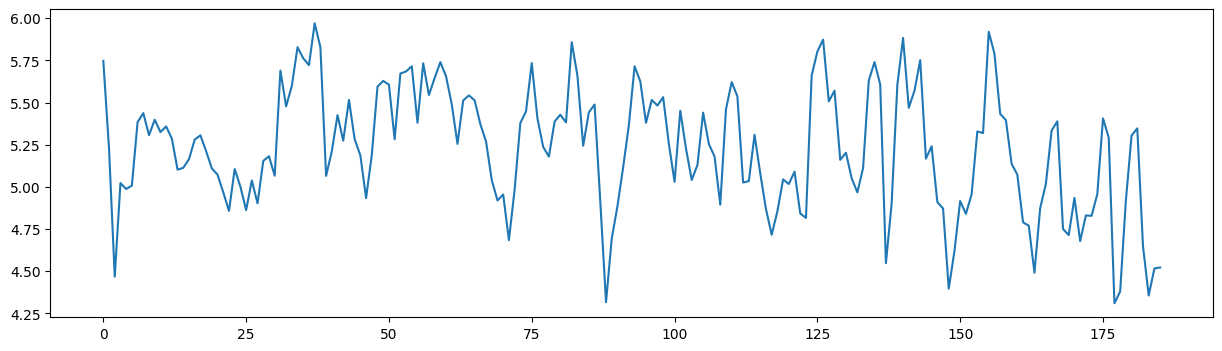

In [95]:
monthly_pm25 = np.log(delhi_pm25)[delhi_pm25.index.month==1]
plt.plot( range(len(monthly_pm25)) ,monthly_pm25)

In [96]:
def resid(_arg1):
    if _arg1[0] == 'XG':
        return (rf2.in_sample_forecast(X_train).reshape(-1) - y_train.values.reshape(-1)).tolist()
    elif _arg1[0] == 'RF':
        return (xg_rf2.in_sample_forecast(X_train).reshape(-1) - y_train.values.reshape(-1)).tolist()
    elif _arg1[0] == 'TBATS':
        return resids_tbats.tolist()
    elif _arg1[0] == 'DHR':
        return resids_dhr.tolist()
    elif _arg1[0] == 'GAM':
        return resids_gam.tolist()
    elif _arg1[0] == 'LSTM':
        return resids_lstm.tolist()

In [97]:
def test_fun(_arg1):
    
    print(_arg1[0])
    if _arg1[0] == 'XG':
        return forecast_xg.tolist()
    elif _arg1[0] == 'RF':
        return forecast_rf.tolist()
    elif _arg1[0] == 'TBATS':
        return forecast_tbats.tolist()
    elif _arg1[0] == 'DHR':
        return forecast_dhr.tolist()
    elif _arg1[0] == 'GAM':
        return forecast_gam.tolist()
    elif _arg1[0] == 'LSTM':
        return forecast_lstm.tolist()

In [98]:
def fitted(_arg1):
    if _arg1[0] == 'XG':
        return fitted_xg.tolist()
    elif _arg1[0] == 'RF':
        return fitted_rf.tolist()
    elif _arg1[0] == 'TBATS':
        return fitted_tbats.tolist()
    elif _arg1[0] == 'DHR':
        return fitted_dhr.tolist()
    elif _arg1[0] == 'GAM':
        return fitted_gam.tolist()
    elif _arg1[0] == 'LSTM':
        return fitted_lstm.tolist()

In [99]:
def entire(_arg1):
    if _arg1[0] == 'XG':
        return entire_xg
    elif _arg1[0] == 'RF':
        return entire_rf
    elif _arg1[0] == 'TBATS':
        return entire_tbats
    elif _arg1[0] == 'DHR':
        return entire_dhr
    elif _arg1[0] == 'GAM':
        return entire_gam

In [101]:
from tabpy.tabpy_tools.client import Client

client = Client('http://localhost:9006/')

In [102]:
client.set_credentials('Rahul', 'REDACTED')

In [103]:
client.deploy('test_fun', test_fun, override = True)

In [104]:
client.deploy('Residuals', resid, override = True)

In [105]:
client.deploy('Fitted', fitted, override = True)

In [106]:
client.deploy('Entire', entire, override = True)

In [109]:
#(client.query('Residuals', ['GAM']))

{'response': [0.26765681839848376,
  -0.3858063407197072,
  0.056984455132166545,
  -0.3605428163297182,
  -0.0950894847969046,
  -0.21062000944642012,
  0.2226811540832303,
  0.023662863695546932,
  -0.09833851176802444,
  0.06902168034918876,
  -0.06615380669213078,
  0.029966853342020983,
  -0.07099866299469682,
  -0.19604415496991479,
  -0.07198694056501154,
  -0.035233952411422464,
  0.058759628424892796,
  0.016665093561658573,
  -0.07922376230163586,
  -0.11684755067775487,
  -0.09167525074027782,
  -0.17325434125277894,
  0.11254170212852976,
  -0.1058424861959919,
  -0.13323043032851256,
  -0.2169440831334466,
  0.05039497370648682,
  -0.20573973450069794,
  0.15914467714317926,
  0.008267051917183466,
  -0.08848560988633469,
  0.2677685218517585,
  -0.17589003979682793,
  -0.013668203259680212,
  -0.1598135330287498,
  -0.09441919569532153,
  0.05939166198875867,
  0.036871400772669816,
  -0.0849759545677955,
  -0.09024804106365014,
  0.0831775051506396,
  -0.2657750815134756

In [137]:
#len((client.query('test_fun', ['GAM']))['response'])

329

In [138]:
#(client.query('Fitted', ['GAM']))

{'response': [239.66897904958012,
  273.83105714385573,
  194.40181726307128,
  217.7549071514294,
  173.38648316983983,
  184.64698353442603,
  174.37594564885867,
  224.5205116450476,
  222.50061984774243,
  206.28133496161425,
  219.45953700621752,
  206.14402088081692,
  212.15457564697147,
  199.99419539684212,
  178.59744268176715,
  181.25599998044052,
  185.25301681601638,
  198.18005419715706,
  198.46927293544869,
  186.15811414868287,
  174.85953308270547,
  170.8572556966841,
  159.07449123543728,
  183.4017988913445,
  169.7608054710235,
  160.67373097422774,
  146.61888079797697,
  165.3512362789343,
  147.65789536043383,
  176.56924250655837,
  173.26570034867086,
  161.88494331687744,
  195.10712132254278,
  159.87914415579283,
  161.04460296446723,
  144.81150109048653,
  142.8552419217991,
  154.93086146538457,
  158.2316945750504,
  147.38535662607163,
  140.85237890383473,
  152.49574906517262,
  125.77780412753204,
  168.8238698400643,
  152.900930481092,
  171.892

In [112]:
#(client.query('Entire', ['GAM']))

{'response': [310.36206309856414,
  295.75598380513657,
  202.22024096579904,
  217.70926703878672,
  168.22782152186795,
  175.35115933103157,
  168.51291910598547,
  214.73110370854255,
  223.58870177892285,
  198.01471241102553,
  224.02887919796427,
  197.82012807123678,
  217.3101990117111,
  193.87804953455662,
  177.91771737657896,
  178.40265349845205,
  180.39063657684036,
  200.5708709152346,
  193.05214186841636,
  189.74496832334427,
  170.26148373213093,
  171.01194381803145,
  155.74950617188816,
  181.15120280449082,
  168.45952292718127,
  156.3477256224651,
  145.4604223736098,
  157.90023108639247,
  146.89523853765604,
  168.86765377765173,
  172.68344687523154,
  156.02676881362174,
  194.6408243422331,
  154.31291483742436,
  159.9540749893261,
  139.75337863518655,
  138.0187463933469,
  152.01945898611854,
  149.73168494228693,
  147.0343363030906,
  132.21026254357935,
  150.8313447190773,
  118.77685846696576,
  164.94660007779137,
  147.13376077263877,
  166.0

In [343]:
def bins(_arg1):
    return([min(resids_tbats) + (i* (np.ptp(resids_tbats)/7)) for i in range(7)])

In [341]:
max(resids_tbats) -  0.4674381617995014

0.33555662794357577

In [222]:
from scipy.fft import fft, ifft
y = fft(delhi_pm25.values)

In [426]:
indices = np.argsort(np.abs(fft))[-3:-2]
k_freq = fft[indices]
k_amp = np.abs(k_freq)
k_phase = np.angle(k_freq)

freq_domain = np.zeros(len(delhi_pm25), dtype = complex)

freq_domain[indices] = k_freq
freq_domain
    
season_real = np.fft.ifft(freq_domain).real
season_imag = np.fft.ifft(freq_domain).imag

In [447]:
fft = np.fft.fft(delhi_pm25)
indices = np.argsort(np.abs(fft))[-12:-1]

fourier_terms = []
for i in range(1,12):
    ind = indices[-i]
    freq_domain = np.zeros(len(delhi_pm25), dtype =  complex)
    freq_domain[ind] = fft[ind]
    season_real = np.fft.ifft(freq_domain).real
    season_imag = np.fft.ifft(freq_domain).imag
    fourier_terms.append(season_real)
    fourier_terms.append(season_imag)
    

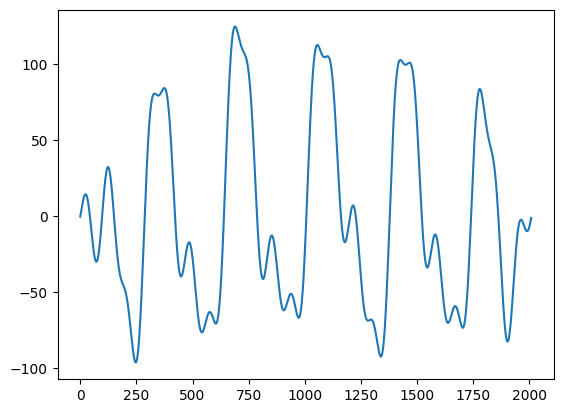

In [448]:
plt.plot(np.array(fourier_terms).sum(axis=0))

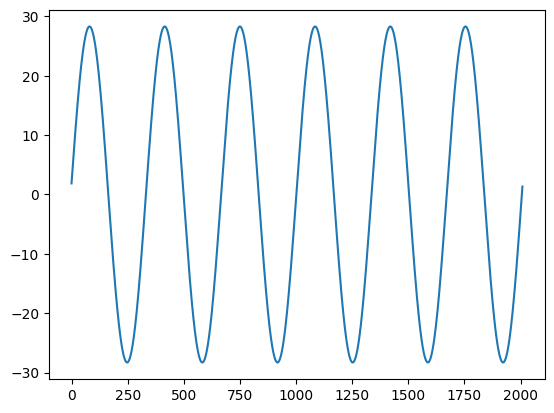

In [427]:
plt.plot(season_real)

In [632]:
(delhi_pm25.index.year.values) + (delhi_pm25.index.month.values)

'[2015 2015 2015 ... 2020 2020 2020][1 1 1 ... 6 6 7]'

In [648]:
np.char.add((delhi_pm25.index.year.values).astype('str'),(delhi_pm25.index.month.values).astype('str'))

array(['20151', '20151', '20151', ..., '20206', '20206', '20207'],
      dtype='<U42')

In [647]:
tst = delhi_pm25.astype('category')
tst.values

/Users/rahulsingh/miniconda3/lib/python3.10/site-packages/IPython/lib/pretty.py:778: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  output = repr(obj)


[313.223043, 186.178333, 87.176667, 151.840000, 146.598333, ..., 39.804583, 59.522500, 44.861667, 39.800000, 54.010000]
Length: 2009
Categories (2005, float64): [10.243333, 10.875000, 11.813810, 14.591667, ..., 582.277500, 588.393333, 639.194167, 685.364167]

https://www.kaggle.com/code/neerajmohan/randomforest-model-with-bayesian-optimization

In [164]:
compression_opts = dict(method='zip',
                        archive_name='out2.csv')  
pd.DataFrame(delhi_pm25).to_csv('out2.zip',
          compression=compression_opts)